In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import shap
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from classo import clr, classo_problem
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import wilcoxon
from sklearn.model_selection import KFold
import regex as re
import seaborn as sns
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
biome = pd.read_csv('X_data.csv', delimiter=',', engine="c",
                index_col=0, dtype=defaultdict(np.float64, {0: str}))
metadata = pd.read_csv('meta_data.csv', delimiter=',', engine="c",
                index_col=0, dtype=str)

(5976, 453)


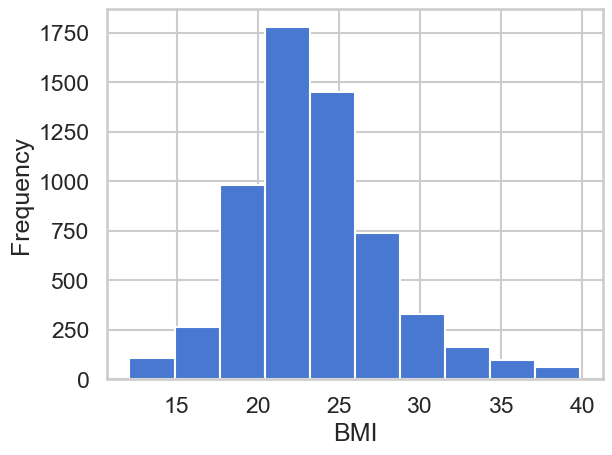

In [88]:
# Preprocessing
bmi_known = ((~metadata["bmi"].isna()) &
       (metadata["bmi"] != "Unspecified") &
       (metadata["bmi"] != "unknown"))

bmi_reasonable = ((metadata.loc[bmi_known, "bmi"].astype(np.float64) >= 12) &
        (metadata.loc[bmi_known, "bmi"].astype(np.float64) <= 40))

featurelist = ["age_corrected", "sex", "exercise_frequency" ]
                              

features_known = ((~metadata[featurelist].isna()) &
                   (metadata[featurelist] != "Unspecified") &
                   (metadata[featurelist] != "unknown") &
                    (metadata[featurelist] != "other")).all(1)

adult = metadata.loc[features_known, "age_corrected"].astype(np.float64) >= 20

ind = bmi_reasonable & features_known # & adult

X_feature_extraction = metadata.loc[ind, ("age_corrected", "sex", 
                                          "exercise_frequency")]

X_features_onehot = pd.concat([X_feature_extraction["age_corrected"],
                      X_feature_extraction["sex"] == "male",
                      pd.get_dummies(X_feature_extraction["exercise_frequency"], drop_first=True)], axis=1).astype(np.float64)

X_features = pd.concat([X_feature_extraction["age_corrected"],
                      X_feature_extraction["sex"] == "male",
                      X_feature_extraction["exercise_frequency"].map({'Regularly (3-5 times/week)':3, 
                                                                      'Occasionally (1-2 times/week)':2, 
                                                                      'Daily':4,
                                                                      'Rarely (a few times/month)':1, 
                                                                      'Never':0})], axis=1).astype(np.float64)


X = biome.loc[ind, np.mean(biome != 0, axis=0) > 0.3].astype(np.float64)
Z = X / ((np.sum(X, axis=1)).values[:, np.newaxis])

X_clr = clr(X, 1/2)

Z_model = pd.concat([Z, X_features], axis=1)
X_clr_model = np.c_[X_clr, X_features_onehot]
#pd.concat([X_clr, X_features], axis=1)

y = metadata.loc[ind, "bmi"].astype(np.float64)
y.name = "BMI"
print(Z_model.shape)
X_features.columns = ["Age", "Sex", "Exercise frequency"]

X_train, X_test, Z_train, Z_test, y_train,  y_test      =      train_test_split(X_clr_model, Z_model, y,  test_size=0.5, random_state=42)
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('muted')
plt.hist(y)
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.savefig('BMI', bbox_inches='tight')

You have mixed positional and keyword arguments, some input may be discarded.


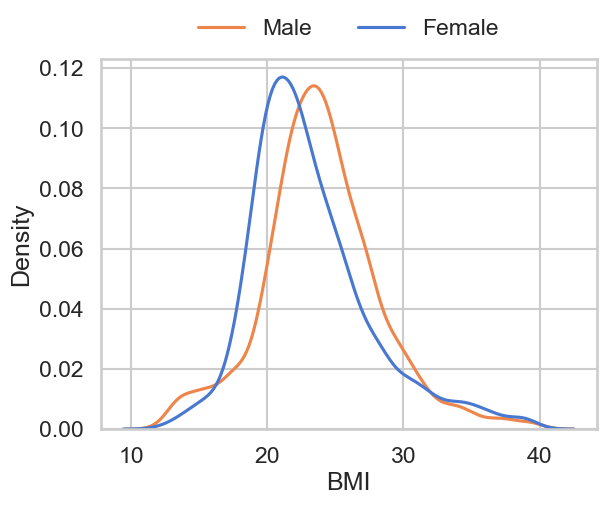

In [89]:
ax = sns.kdeplot(x = y, hue=X_features['Sex'], common_norm=False)
sns.move_legend(ax, loc='lower center', ncol = 2, frameon=False, title=None, bbox_to_anchor=[0.5, 1], labels = ['Male', 'Female'])
plt.savefig('bmi_sex_density.png', bbox_inches='tight')

You have mixed positional and keyword arguments, some input may be discarded.


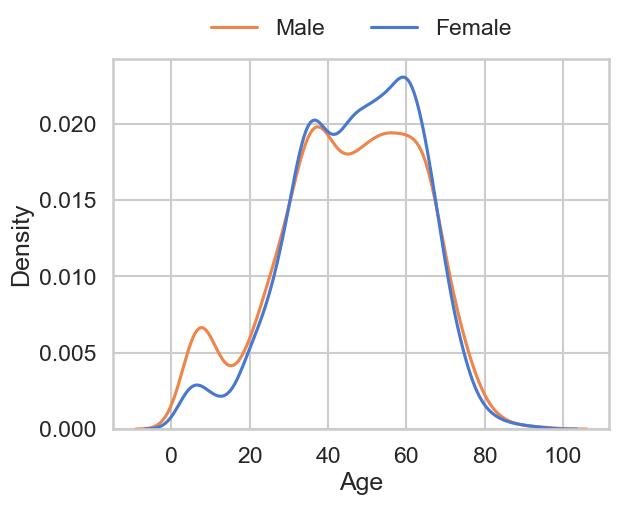

In [90]:
ax = sns.kdeplot(x = X_features['Age'], hue=X_features['Sex'], common_norm=False)
sns.move_legend(ax, loc='lower center', ncol = 2, frameon=False, title=None, bbox_to_anchor=[0.5, 1], labels = ['Male', 'Female'])
plt.savefig('age_sex_density.png', bbox_inches='tight')

In [6]:
print("in total there are", metadata.shape[0], "observations")
print("Of these,", np.sum(bmi_known), "have known bmi and", np.sum(bmi_reasonable), "are reasonable.")
print("When we exclude observations with unknown features we are left with", np.sum(features_known & bmi_reasonable) ,"observations.")

in total there are 7203 observations
Of these, 6993 have known bmi and 6560 are reasonable.
When we exclude observations with unknown features we are left with 5976 observations.


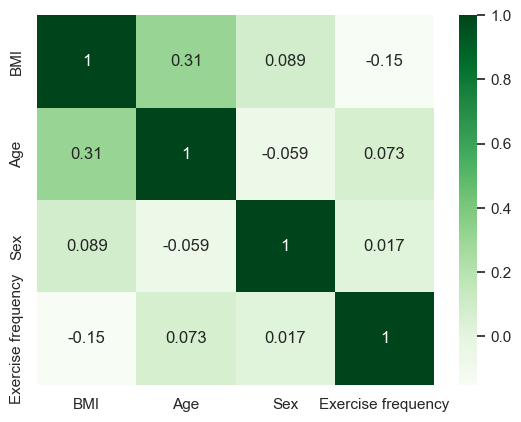

In [54]:
sns.heatmap(pd.merge(y, X_features, left_index=True, right_index=True).corr(), cmap=plt.cm.Greens, annot=True)
plt.savefig("corrbmiplot.png", bbox_inches='tight')

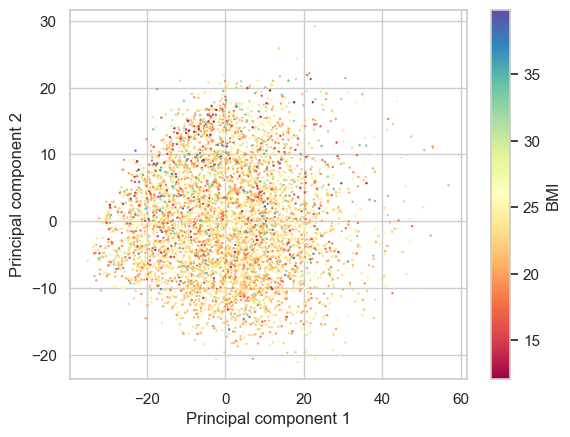

In [70]:
pca = PCA(n_components=2)
pca.fit(X_clr)
X_pca = pca.transform(X_clr)
plt.scatter(X_pca[:,0], X_pca[:,1], s = 0.5, c = y, cmap='Spectral')
plt.xlabel('Principal component 1')
plt.colorbar(label = "BMI")
plt.ylabel('Principal component 2')
plt.savefig('pcaplot.png', bbox_inches='tight')  

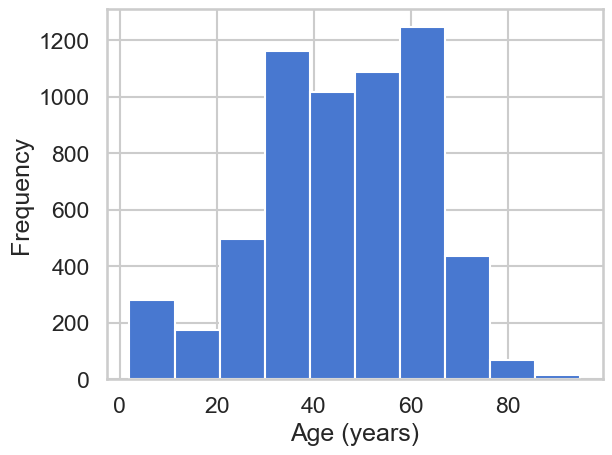

In [92]:
plt.hist(X_features['Age'])
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.savefig('age.png', bbox_inches='tight')

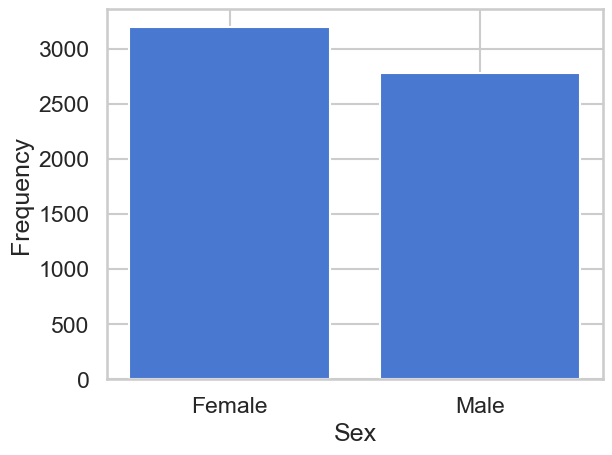

In [93]:
plt.bar((0,1), (np.sum(1-X_features['Sex']), np.sum(X_features['Sex'])))
plt.xlabel('Sex')
plt.xticks([0,1], ['Female', 'Male'])
plt.ylabel('Frequency')
plt.savefig('sex.png', bbox_inches='tight')

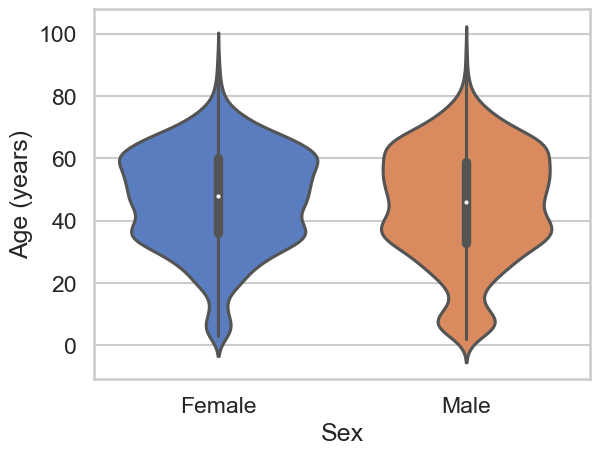

In [94]:
sns.violinplot(data = X_features, x = 'Sex', y = 'Age')
plt.xticks([0,1], ['Female', 'Male'])
plt.ylabel('Age (years)')
plt.savefig('sex_age_corr.png', bbox_inches='tight')

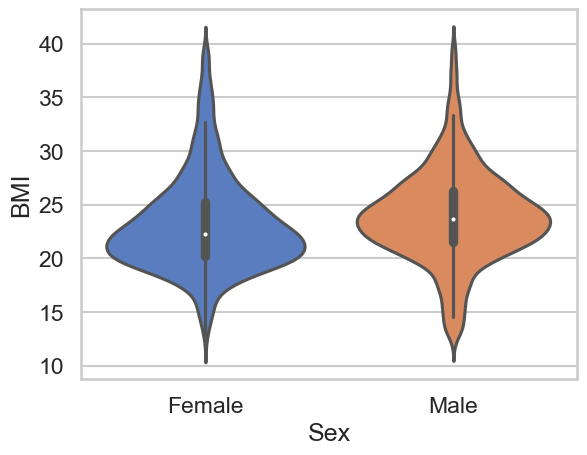

In [95]:
sns.violinplot(data = X_features, x = 'Sex', y = y)
plt.xticks([0,1], ['Female', 'Male'])
# plt.ylabel("BMI")
plt.savefig('sex_bmi_corr.png', bbox_inches='tight')

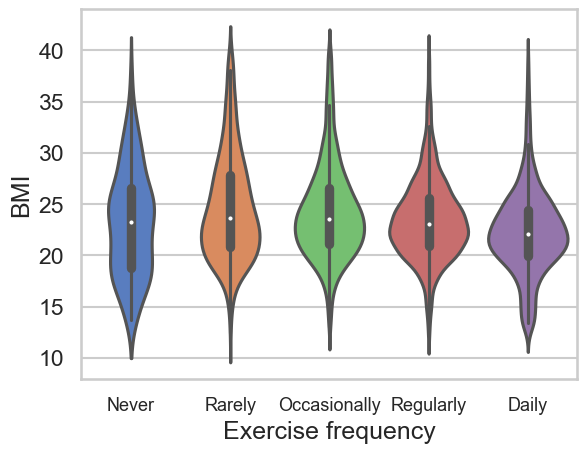

In [105]:
sns.violinplot(data = X_features, x = 'Exercise frequency', y = y)
plt.xticks((3,2,4,1,0), ('Regularly','Occasionally', 'Daily', 'Rarely', 'Never'), fontsize=13)
plt.savefig('bmi_exercise_corr.png', bbox_inches='tight')

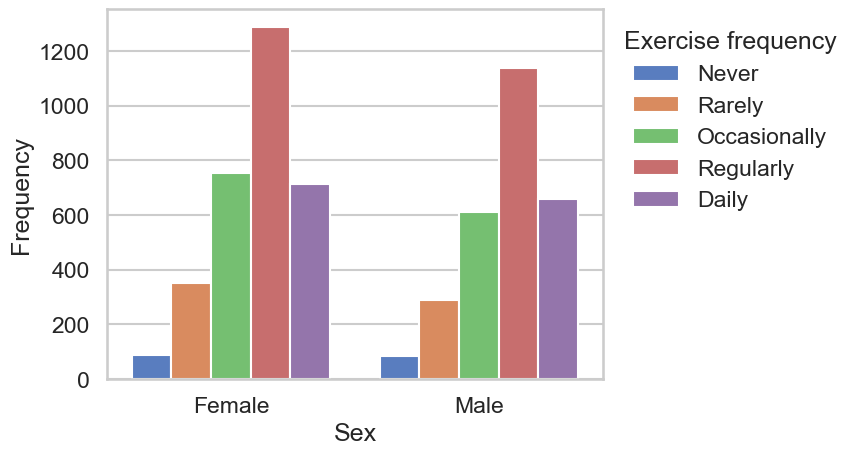

In [97]:
ax = sns.countplot(x = X_features['Sex'], hue = X_features['Exercise frequency'])
plt.xticks([0,1], ['Female', 'Male'])
plt.ylabel('Frequency')
plt.legend(title = "Exercise frequency", labels = ['Never', 'Rarely','Occasionally','Regularly', 'Daily'])
sns.move_legend(ax, loc = 'upper left', bbox_to_anchor = [1,1], frameon=False)
plt.savefig('sex_exercise_interaction.png', bbox_inches='tight')

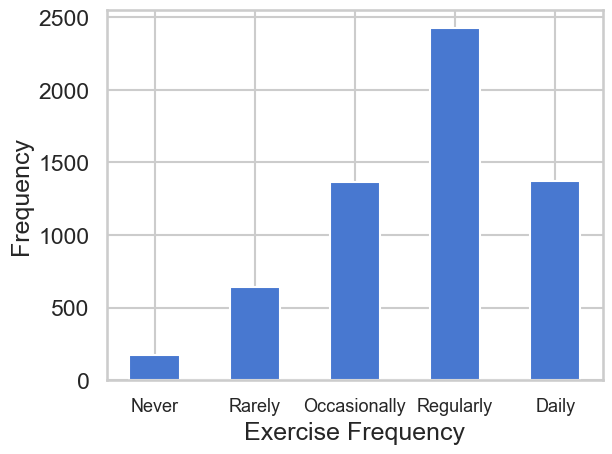

In [106]:
plt.hist(X_features['Exercise frequency'], bins=np.arange(-0.25, 4.75, 0.5))
plt.xlabel('Exercise Frequency')
plt.xticks((3,2,4,1,0), ('Regularly','Occasionally', 'Daily', 'Rarely', 'Never'))
plt.xticks(fontsize=13)  
plt.ylabel('Frequency')
plt.savefig('exercisefreq', bbox_inches='tight')

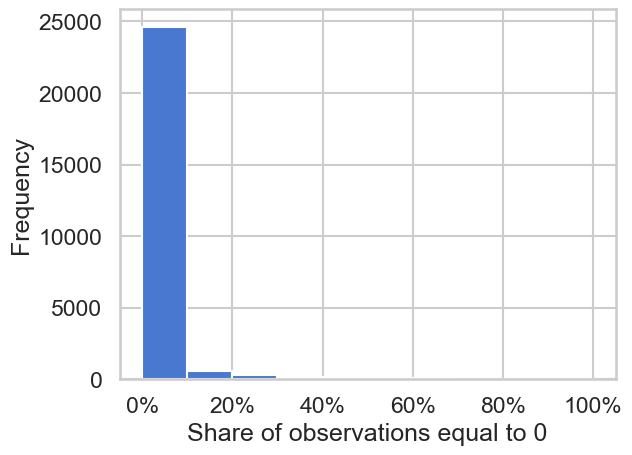

In [107]:
# All features
plt.hist(np.mean(biome != 0, axis=0),bins = np.arange(0,1.1,0.1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Share of observations equal to 0')
plt.ylabel('Frequency')
plt.savefig('missing_hist_1', bbox_inches = 'tight')

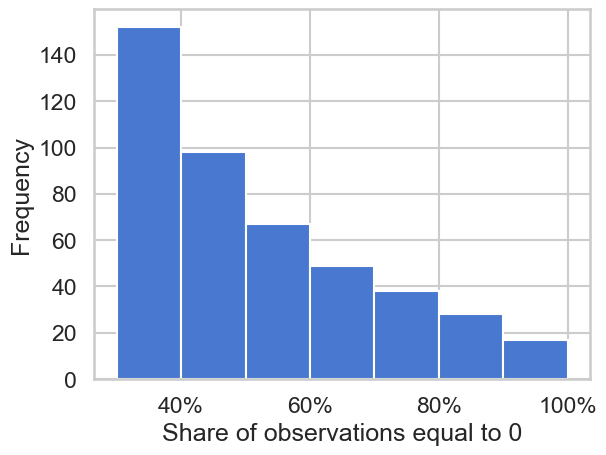

In [108]:
# Included Features
plt.hist(np.mean(X != 0, axis=0), bins = np.arange(0.3,1.1,0.1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Share of observations equal to 0')
plt.ylabel('Frequency')
plt.savefig('missing_hist_2',bbox_inches = 'tight')